# TorchVision Instance Segmentation Finetuning with mixed data
Adapted from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-dh0zwa2u
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-dh0zwa2u
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264361 sha256=e4ef7f66a0d353fe9ec9ea69f88a702d4fe5177632975abaa7afb60fa84ff877
  Stored in directory: /tmp/pip-ephem-wheel-cache-q6hym4sn/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation


### Writing a custom dataset for Penn-Fudan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/generated_datasets/"

# !cp "/content/drive/My Drive/generated_datasets/generated_0326.zip" /content/
# !unzip generated_0326.zip

!cp "/content/drive/My Drive/generated_datasets/generated_0328.zip" /content/
!unzip generated_0328.zip

Mounted at /content/drive
generated_0317-576.zip	   generated_0322.zip	 generated_0325.zip
generated_0319-263.zip	   generated_0323_2.zip  generated_0326.zip
generated_0320.zip	   generated_0323.zip	 generated_0327.zip
generated_0321.zip	   generated_0324.zip	 generated_0328_2.zip
generated_0322_aws.tar.gz  generated_0325_2.zip  generated_0328.zip
Archive:  generated_0328.zip
   creating: generated_0328/
   creating: generated_0328/render/
  inflating: generated_0328/render/img_6c8c858581de4b9db97ac3a086c60829_f1.0.png  
  inflating: generated_0328/render/img_6c8c858581de4b9db97ac3a086c60829_f16.0.png  
  inflating: generated_0328/render/img_add886a5ee81493e9b863d6542bfcd46_f1.0.png  
  inflating: generated_0328/render/img_add886a5ee81493e9b863d6542bfcd46_f16.0.png  
  inflating: generated_0328/render/img_c3644d63facd43db8bbd2c1dacc29305_f1.0.png  
  inflating: generated_0328/render/img_c3644d63facd43db8bbd2c1dacc29305_f16.0.png  
  inflating: generated_0328/render/img_bdc3253179f34d0d

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2022-03-29 23:42:40--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  30.1MB/s    in 1.7s    

2022-03-29 23:42:42 (30.1 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-03-29 23:42:42--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-03-29 23:42:42--
Total wall clock time: 2.1s
Downloaded: 1 files, 51M in 1.7s (30.1 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [ ]:
# import os
# PenFudanPed_img_dir = "/content/PennFudanPed/PNGImages"
# for count, filename in enumerate(os.listdir(PenFudanPed_img_dir)):
#     dst = f"img_00{str(count)}.png"
#     src =f"{PenFudanPed_img_dir}/{filename}"  # foldername/filename, if .py file is outside folder
#     dst =f"/content/generated/render/{dst}"
#     os.rename(src, dst)
# PenFudanPed_mask_dir = "/content/PennFudanPed/PedMasks"
# for i, filename in enumerate(os.listdir(PenFudanPed_mask_dir)):
#     dst = f"mask_00{str(i)}.png"
#     src =f"{PenFudanPed_mask_dir}/{filename}"  # foldername/filename, if .py file is outside folder
#     dst =f"/content/generated/masks/{dst}"
#     os.rename(src, dst)


## Defining your model


### 1 - Finetuning from a pretrained model


### 2 - Modifying the model to add a different backbone


### An Instance segmentation model for PennFudan Dataset


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 113441, done.
remote: Counting objects: 100% (6125/6125), done.
remote: Compressing objects: 100% (1052/1052), done.
remote: Total 113441 (delta 5605), reused 5411 (delta 5042), pack-reused 107316
Receiving objects: 100% (113441/113441), 222.46 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (98266/98266), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

Train on pixelart dataset

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json

class PixalArtDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        json_path = os.path.join(self.root, "dataset_best.json")
        json_file = open(json_path)
        dataset = json.load(json_file)
        json_file.close()
        images = []
        for scenario in dataset:
          cur_imgs = []
          for image in scenario["images"]:
            cur_imgs.append((scenario["id"], image, scenario["masks"]))
          images += cur_imgs
        self.imgs = images

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "render/", self.imgs[idx][1]["filename"]+".png")
        masks = []
        boxes = []
        sanitized_objects_num = 0
        for i, mask_data in enumerate(self.imgs[idx][2]):
          mask_path = os.path.join(self.root, "masks/", mask_data["mask_name"]+".npy")
          unchecked_mask = np.load(mask_path)
          #print(unchecked_mask.shape)
          if np.count_nonzero(unchecked_mask)/(unchecked_mask.shape[0]*unchecked_mask.shape[1]) > 0.02:
            masks.append(unchecked_mask)
            boxes.append(mask_data["bbox"])
            sanitized_objects_num += 1
            
        img = Image.open(img_path).convert("RGB")
        if len(boxes) == 0:
          return None, None
        # get bounding box coordinates for each mask
        num_objs = sanitized_objects_num
        

        boxes = torch.as_tensor(np.array(boxes), dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = torch.tensor(0.0)
        if len(boxes) and len(boxes[0]):
          #print(boxes)
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json

class PixalArtDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        json_path = os.path.join(self.root, "dataset_best.json")
        json_file = open(json_path)
        dataset = json.load(json_file)
        json_file.close()
        images = []
        for scenario in dataset:
          cur_imgs = []
          for image in scenario["images"]:
            cur_imgs.append((scenario["id"], image, scenario["masks"]))
          images += cur_imgs
        self.imgs = images

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "render/", self.imgs[idx][1]["filename"]+".png")
        masks = []
        boxes = []
        sanitized_objects_num = 0
        for mask_data in self.imgs[idx][2]:
          mask_path = os.path.join(self.root, "masks/", mask_data["mask_name"]+".npy")
          masks.append(np.load(mask_path))
          boxes.append(mask_data["bbox"])
            
        img = Image.open(img_path).convert("RGB")
        if len(boxes) == 0:
          return None, None
        # get bounding box coordinates for each mask
        num_objs = len(self.imgs[idx][2])
        

        boxes = torch.as_tensor(np.array(boxes), dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(np.array(boxes), dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
import math
import sys
import time
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
    res_loss = []
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        # skip = False
        # for img in images:
        #   if img == None:
        #     skip = True
        #     break

        # if skip:
        #   continue
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        del images
        del targets
        torch.cuda.empty_cache()
        
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        res_loss.append(losses_reduced)

    return metric_logger, res_loss

def get_instance_segmentation_model(num_classes, hidden=32):
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = hidden
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)

  return model

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/446]  eta: 0:10:02  lr: 0.000032  loss: 6.7375 (6.7375)  loss_classifier: 0.5564 (0.5564)  loss_box_reg: 0.3817 (0.3817)  loss_mask: 5.7918 (5.7918)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.3509  data: 0.4997  max mem: 2650
Epoch: [0]  [ 10/446]  eta: 0:03:47  lr: 0.000257  loss: 2.8609 (3.7324)  loss_classifier: 0.4790 (0.4584)  loss_box_reg: 0.3004 (0.3213)  loss_mask: 2.1557 (2.9382)  loss_objectness: 0.0040 (0.0065)  loss_rpn_box_reg: 0.0050 (0.0080)  time: 0.5215  data: 0.0568  max mem: 3592
Epoch: [0]  [ 20/446]  eta: 0:03:24  lr: 0.000481  loss: 1.4881 (2.4779)  loss_classifier: 0.2451 (0.3397)  loss_box_reg: 0.3004 (0.3168)  loss_mask: 0.8506 (1.8036)  loss_objectness: 0.0078 (0.0106)  loss_rpn_box_reg: 0.0062 (0.0073)  time: 0.4362  data: 0.0120  max mem: 3592
Epoch: [0]  [ 30/446]  eta: 0:03:12  lr: 0.000706  loss: 0.8785 (1.9466)  loss_classifier: 0.1840 (0.2817)  loss_box_reg: 0.2859 (0.3017)  loss_mask: 0.4654 (1.3438) 

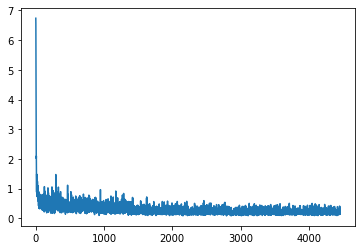

In [ ]:
import torchvision


torch.cuda.empty_cache()

batch_size = 2
num_epochs = 10
num_classes = 2
hidden = 1024
lr=0.01
momentum=0.9
weight_decay=0.0005

dataset_syn = PixalArtDataset('/content/generated_0328', get_transform(train=True))
# dataset = torch.utils.data.ConcatDataset([PennFudanDataset('/content/PennFudanPed', get_transform(train=True)), PixalArtDataset('/content/generated_0328', get_transform(train=True))])
#dataset = PixalArtDataset('/content/generated_0328', get_transform(train=True))
# dataset_test = torch.utils.data.ConcatDataset([PixalArtDataset('/content/generated_0322', get_transform(train=False)), PennFudanDataset('/content/PennFudanPed', get_transform(train=True))])
# dataset = PennFudanDataset('/content/PennFudanPed', get_transform(train=True))
dataset_real = PennFudanDataset('/content/PennFudanPed', get_transform(train=False))
#dataset_test = PixalArtDataset('/content/generated_0322', get_transform(train=False))


# split the dataset in train and test set
# torch.manual_seed(1)
test_indices = torch.randperm(len(dataset_real)).tolist()
dataset_test = torch.utils.data.Subset(dataset_real, test_indices[(-int((len(test_indices)/4))):])
dataset_real_train = torch.utils.data.Subset(dataset_real, test_indices[:-int((len(test_indices)/4))])

dataset = torch.utils.data.ConcatDataset([dataset_real_train, dataset_syn])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)


def plot_loss(losses):
  cpu_loss = []
  for loss in losses:
    cpu_loss.append(loss.cpu().detach().numpy())
  plt.plot(cpu_loss)

from engine import evaluate
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person

# get the model using our helper function
model = get_instance_segmentation_model(num_classes, hidden=hidden)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                         step_size=3,
                         gamma=0.1)

losses = []
val_res = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger, train_loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    coco_evaluator = evaluate(model, data_loader_test, device=device)
    #print("Train Loss: {}".format(train_loss))
    losses += train_loss
checkpoint_path = "/content/drive/My Drive/ECE496 Team/object_detection/maskrcnn_checkpoints/"+"bs{}_hidden{}_lr{}_epoch{}.pt".format(batch_size, hidden, lr, epoch)
torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': losses,
      }, checkpoint_path)
plot_loss(losses)

In [ ]:
# pick one image from the test set
img, _target = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

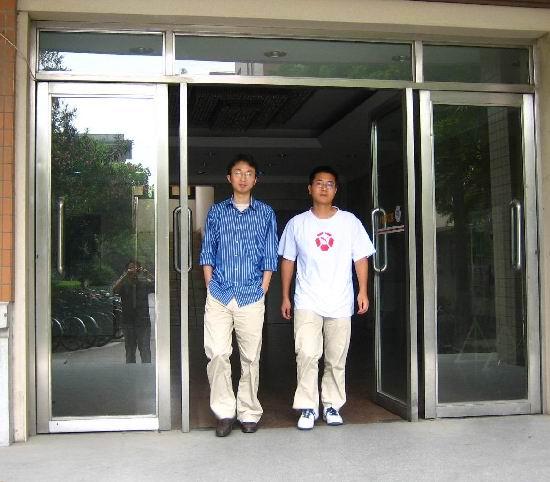

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
dataset_test1 = torch.utils.data.ConcatDataset([PixalArtDataset('/content/generated_0322', get_transform(train=False)), PennFudanDataset('/content/PennFudanPed', get_transform(train=False))])
test_indices1 = torch.randperm(len(dataset_test1)).tolist()
dataset_test1 = torch.utils.data.Subset(dataset_test1, test_indices1[(-int((len(dataset_test1)/5))):])
data_loader_test1 = torch.utils.data.DataLoader(
    dataset_test1, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)
coco_evaluator = evaluate(model, data_loader_test1, device=device)

SyntaxError: ignored

In [ ]:
import torchvision

torch.cuda.empty_cache()

batch_size = 2
num_epochs = 10
num_classes = 2
hidden = 1024
lr=0.01
momentum=0.9
weight_decay=0.0005

from engine import evaluate
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person

# get the model using our helper function
model1 = get_instance_segmentation_model(num_classes, hidden=hidden)
# move model to the right device


# construct an optimizer
params = [p for p in model1.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)


# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                         step_size=3,
                         gamma=0.1)


model1.to(device)

checkpoint = torch.load("/content/drive/MyDrive/ECE496 Team/object_detection/maskrcnn_checkpoints/best_0328pennfudan_bs2_hidden1024_lr0.01_epoch9.pt")
model1.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model1.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

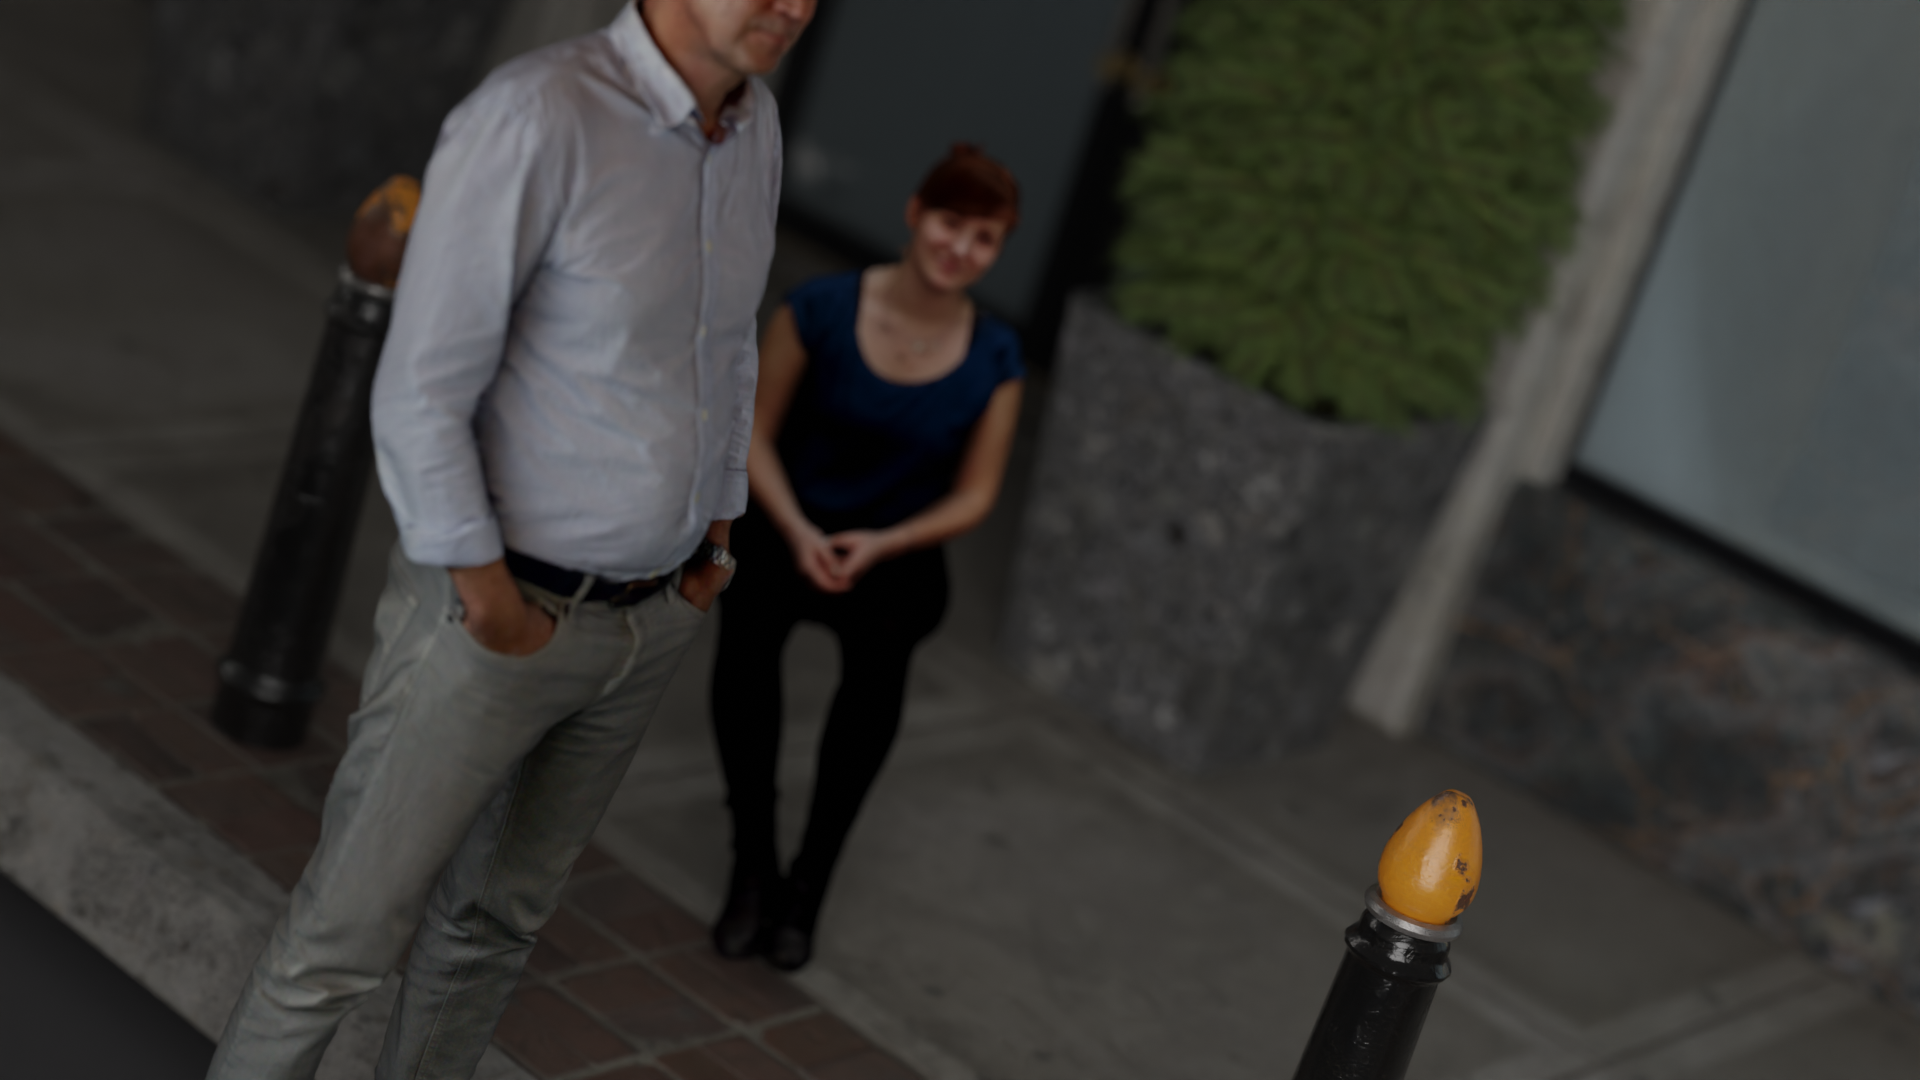

In [ ]:
dataset_test1 = PixalArtDataset('/content/generated_0328', get_transform(train=False))
data_loader_test1 = torch.utils.data.DataLoader(
    dataset_test1, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

# pick one image from the test set
img, _target = dataset_test1[170]
# put the model in evaluation mode
model1.eval()
with torch.no_grad():
    prediction = model1([img.to(device)])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

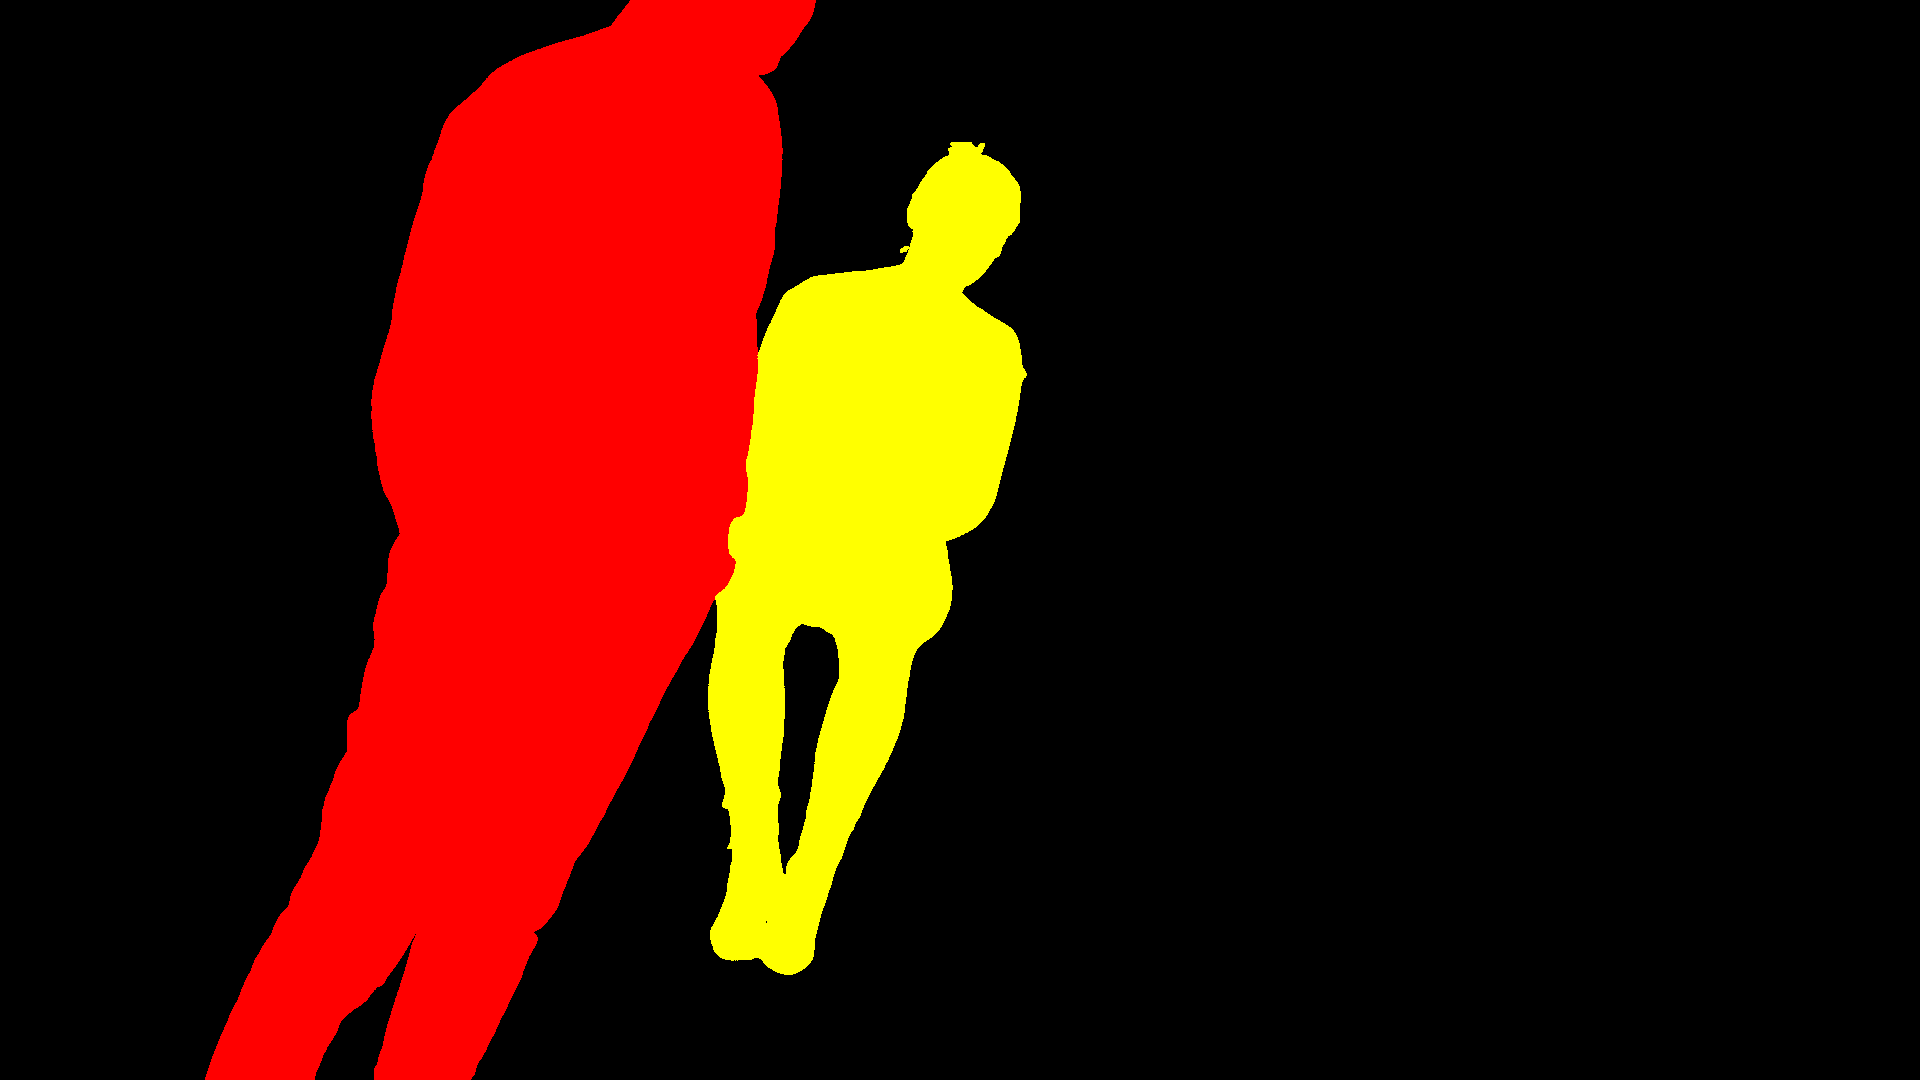

In [ ]:
i = 0
base = _target['masks'][0]
for i in range(1, len(_target['masks'])):
  base = np.maximum(base, (i+1) * _target['masks'][i])
mask_map = Image.fromarray(base.byte().cpu().numpy())
mask_map.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
    255, 153, 255, # index 3 is orange
    0, 153, 255, # index 3 is orange
])
mask_map

In [ ]:
_target['masks'][0].shape[0]

1080

In [ ]:
np.count_nonzero(prediction[0]['masks'][4, 0].cpu().numpy())/(_target['masks'][0].shape[0]*_target['masks'][0].shape[1])

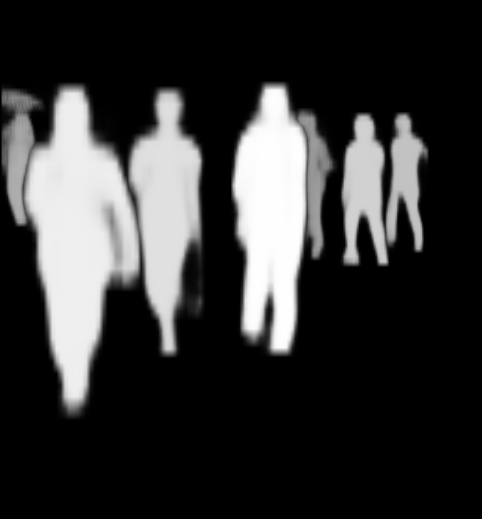

In [ ]:
i = 0
base = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
for i in range(1, 7):
  base = np.maximum(base, prediction[0]['masks'][i, 0].mul(255-15*i).byte().cpu().numpy())
np.clip(base, 0, 254)
#mask_map = Image.fromarray(base).transpose(Image.FLIP_LEFT_RIGHT)
mask_map = Image.fromarray(base)
mask_map.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
    255, 153, 255, # index 3 is orange
    0, 153, 255, # index 3 is orange
])
mask_map

In [ ]:
plt.imshow(prediction[0]['masks'][0, 0].byte().cpu().numpy())


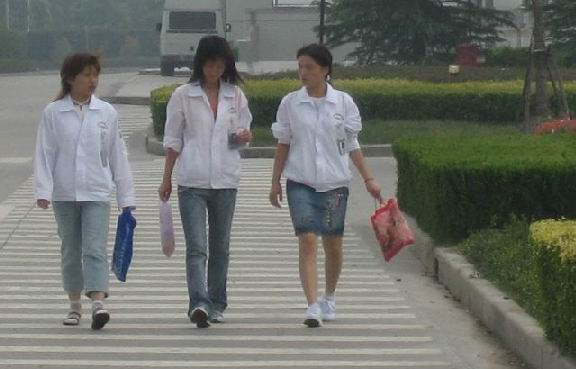

In [ ]:
img = Image.open('PennFudanPed/PNGImages/FudanPed00059.png')
img

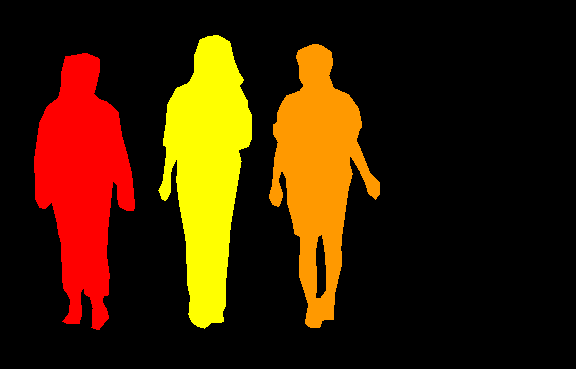

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00059_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
    255, 153, 255, # index 3 is orange
    0, 153, 255, # index 3 is orange
    0, 0, 255, # index 3 is orange
    0, 255, 0, # index 3 is orange
])
mask

In [ ]:
model1.to(device)
coco_evaluator = evaluate(model1, data_loader_test, device=device)